In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt

%matplotlib inline

# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 384  # object size in x,y
nz = 384  # object size in z    
ntheta = 90  # number of angles (rotations)

pnz = nz//4 # tomography chunk size for GPU processing 
ptheta = ntheta # holography chunk size for GPU processing

center = n/2 # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32') # projection angles

# ID16a setup
voxelsize = 1e-6*2048/n # [cm] object voxel size 
energy = 33.35  # [keV] x-ray energy    
focusToDetectorDistance = 128 # [cm]
sx0 = 0.037 # [cm] motor offset from the focal spot
z1 = np.array([0.4584,0.4765,0.5488,0.69895])-sx0 # distances between planes and the focal spot
z2 = focusToDetectorDistance-z1 # distances between planes and the detector
magnifications = focusToDetectorDistance/z1 # actual magnifications
norm_magnifications = magnifications/magnifications[0] # normalized magnifications
distances = (z1*z2)/focusToDetectorDistance # propagation distances after switching from the point source wave to plane wave,
distances = distances*norm_magnifications**2 # scaled propagation distances due to magnified probes

## Read data

In [3]:
data = np.zeros([len(distances),ntheta,nz,n],dtype='float32')
for k in range(4):
    data[k] = dxchange.read_tiff(f'data/modeling/data_chip_{n}_{k}.tiff')[:ntheta]

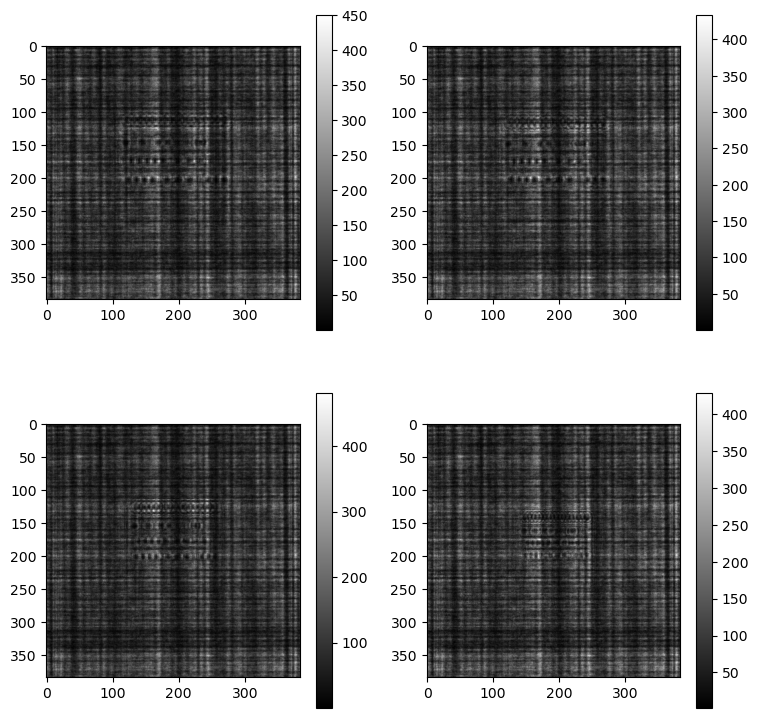

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0],cmap='gray')
fig.colorbar(im)
im=axs[0,1].imshow(data[1,0],cmap='gray')
fig.colorbar(im)
im=axs[1,0].imshow(data[2,0],cmap='gray')
fig.colorbar(im)
im=axs[1,1].imshow(data[3,0],cmap='gray')
fig.colorbar(im)

## Create a solver class for holography

In [5]:
pslv = holotomo.SolverHolo(ntheta, nz, n, ptheta, voxelsize, energy, distances, norm_magnifications)

note ptheta parameter is used to define the number of angles for simultaneous processing by 1 gpu. Currently pntheta=ntheta. If the gpu does not have enough memory then ptheta should  be decreased
norm_magnifications are magnifications for different distances, normalized by the magnification for the first distance

## Read reference images (probes) recovered by the NFP (Near-field ptychogarphy) method at ID16A. There are probes for 4 different distances.

In [6]:
prb_abs = dxchange.read_tiff(f'data/prb_id16a/prb_abs_{n}.tiff')
prb_phase = dxchange.read_tiff(f'data/prb_id16a/prb_phase_{n}.tiff')
prb = prb_abs*np.exp(1j*prb_phase)    
#simplify
#prb[:] = 1

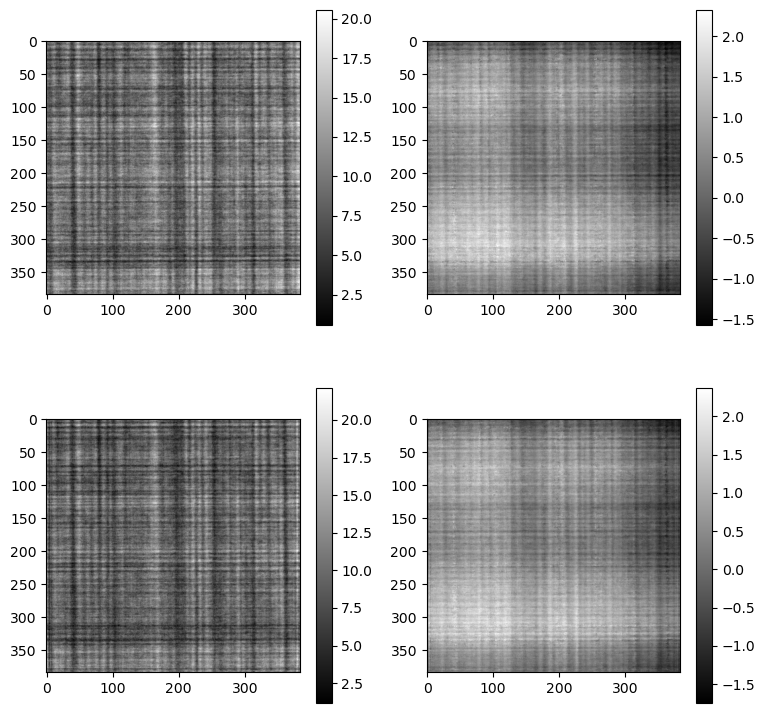

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(np.abs(prb[0]),cmap='gray')
fig.colorbar(im)
im=axs[0,1].imshow(np.angle(prb[0]),cmap='gray')
fig.colorbar(im)
im=axs[1,0].imshow(np.abs(prb[-1]),cmap='gray')
fig.colorbar(im)
im=axs[1,1].imshow(np.angle(prb[-1]),cmap='gray')
fig.colorbar(im)

# Solving the problem $\sum_{k,j}\||\mathcal{G}_kq_k \psi_j|-d_{k,j}\|_2\to min$ with the Conjugate Gradient

In [8]:
import cupy as cp

def line_search(minf, gamma, u, fu, d, fd):
    """ Line search for the step sizes gamma"""
    while(minf(u, fu)-minf(u+gamma*d, fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma
    
def cg_holo(data, init, prb,  piter):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(psi,fpsi):
        f = cp.linalg.norm(cp.abs(fpsi)-cp.sqrt(data))**2            
        # f = cp.linalg.norm(cp.abs(fpsi)**2-data)**2            
        return f        
    psi = init.copy()
    
    maxprb = cp.max(cp.abs(prb))
    gamma = 1# init gamma as a large value
    for i in range(piter):
        fpsi = pslv.fwd_holo(psi,prb)
        grad = pslv.adj_holo(
           fpsi-cp.sqrt(data)*cp.exp(1j*cp.angle(fpsi)), prb)/maxprb**2
        #grad = pslv.adj_holo(
             #(cp.abs(fpsi)**2-data)*fpsi,prb)/maxprb**2
        
        # Dai-Yuan direction
        if i == 0:
            d = -grad
        else:
            d = -grad+cp.linalg.norm(grad)**2 / \
                ((cp.sum(cp.conj(d)*(grad-grad0))))*d
        grad0 = grad
        # line search
        fd = pslv.fwd_holo(d, prb)
        gamma = line_search(minf, gamma, psi, fpsi, d, fd)
        psi = psi + gamma*d
        print(f'{i}) {gamma=}, err={minf(psi,fpsi)}')
    
    return psi

def cg_holo_batch(data, init, prb, piter):
    """Batch of CG solvers"""
    
    res = np.zeros([ntheta, nz, n], dtype='complex64')
    prb_gpu = cp.array(prb)            
    for ids in holotomo.utils.chunk(range(ntheta), ptheta):
        # copy data part to gpu
        data_gpu = cp.array(data[:,ids])
        init_gpu = cp.array(init[ids])
        # Radon transform
        res_gpu = cg_holo(data_gpu, init_gpu,prb_gpu, piter)
        # copy result to cpu
        res[ids] = res_gpu.get()
    return res



piter = 60 # number of CG iters
init = np.ones([ntheta,nz,n],dtype='complex64')  # initial guess
rec = cg_holo_batch(data, init, prb,  piter)


# alternatively
# pslv = holotomo.SolverHolo(ntheta, nz, n, ptheta, voxelsize, energy, distances, norm_magnifications)
# rec = pslv.cg_holo_batch(data,init,prb,piter)



0) gamma=1, err=7154789.0
1) gamma=1, err=2159337.25
2) gamma=1, err=881207.75
3) gamma=1, err=601720.625
4) gamma=1, err=440219.84375
5) gamma=1, err=366645.40625
6) gamma=1, err=300463.625
7) gamma=1, err=266231.6875
8) gamma=1, err=232969.875
9) gamma=1, err=213713.375
10) gamma=1, err=192667.25
11) gamma=1, err=179699.4375
12) gamma=1, err=164804.75
13) gamma=1, err=154629.90625
14) gamma=1, err=147778.890625
15) gamma=1, err=137137.421875
16) gamma=1, err=131994.484375
17) gamma=1, err=123656.6640625
18) gamma=1, err=119496.765625
19) gamma=1, err=116054.7265625
20) gamma=1, err=113207.7109375
21) gamma=1, err=110786.7265625
22) gamma=1, err=108546.8828125
23) gamma=1, err=106610.9765625
24) gamma=1, err=104863.84375
25) gamma=1, err=103057.59375
26) gamma=1, err=101468.8828125
27) gamma=1, err=100021.765625
28) gamma=1, err=98414.875
29) gamma=1, err=97062.75
30) gamma=1, err=95785.3046875
31) gamma=1, err=94332.2890625
32) gamma=1, err=93156.3984375
33) gamma=1, err=92028.039062

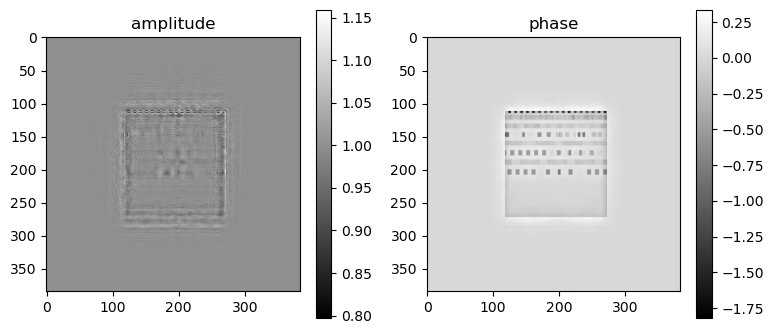

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(rec[0]),cmap='gray')
axs[0].set_title('amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec[0]),cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im)

# Convert the recovered transmittance function to the complex refractive index: $-\frac{i \lambda}{2\pi} \log(\psi)$  

In [10]:
projrec = pslv.logtomo(rec)

# Show sinogram

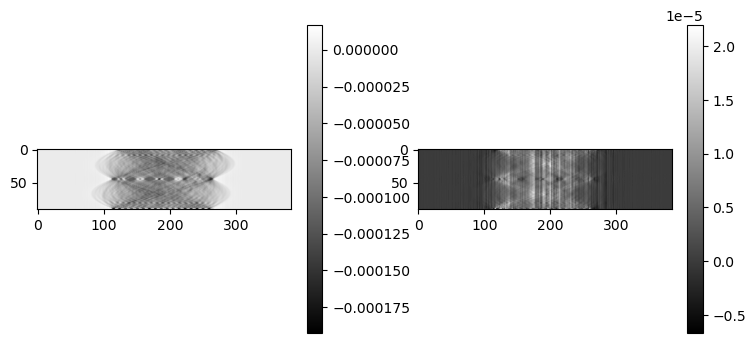

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.real(projrec[:,49+nz//2-128]),cmap='gray')
fig.colorbar(im)
im=axs[1].imshow(np.imag(projrec[:,49+nz//2-128]),cmap='gray')
fig.colorbar(im)

# Solve tomogarphy problem with the Conjugate gradient solver, adding padding data and unpadding reconstruction

In [12]:
with holotomo.SolverTomo(theta, ntheta, nz, n, pnz, center) as tslv:
    init = np.zeros([nz,n,n],dtype='complex64')
    piter = 32
    urec = tslv.cg_tomo_batch(projrec,init,piter)

0) gamma=1, err=4.628866008715704e-06
1) gamma=1, err=2.5867063868645346e-06
2) gamma=1, err=2.2088618152338313e-06
3) gamma=1, err=1.8058002524412586e-06
4) gamma=1, err=1.6808556893010973e-06
5) gamma=1, err=1.5718857184765511e-06
6) gamma=1, err=1.3865060282114428e-06
7) gamma=1, err=1.1255619938310701e-06
8) gamma=1, err=1.0071526048704982e-06
9) gamma=1, err=8.969330451691349e-07
10) gamma=1, err=6.460905410676787e-07
11) gamma=1, err=4.257014438735496e-07
12) gamma=1, err=3.6881212395201146e-07
13) gamma=1, err=3.272339483828546e-07
14) gamma=1, err=2.1307043596152653e-07
15) gamma=1, err=1.6286884374494548e-07
16) gamma=1, err=1.4104016088367644e-07
17) gamma=1, err=1.1836000624043663e-07
18) gamma=1, err=1.011421488783526e-07
19) gamma=1, err=9.420764257583869e-08
20) gamma=1, err=8.318151856201439e-08
21) gamma=1, err=7.006619995308938e-08
22) gamma=1, err=6.333058877316944e-08
23) gamma=1, err=6.071936553553314e-08
24) gamma=1, err=5.00290546767701e-08
25) gamma=1, err=4.7630

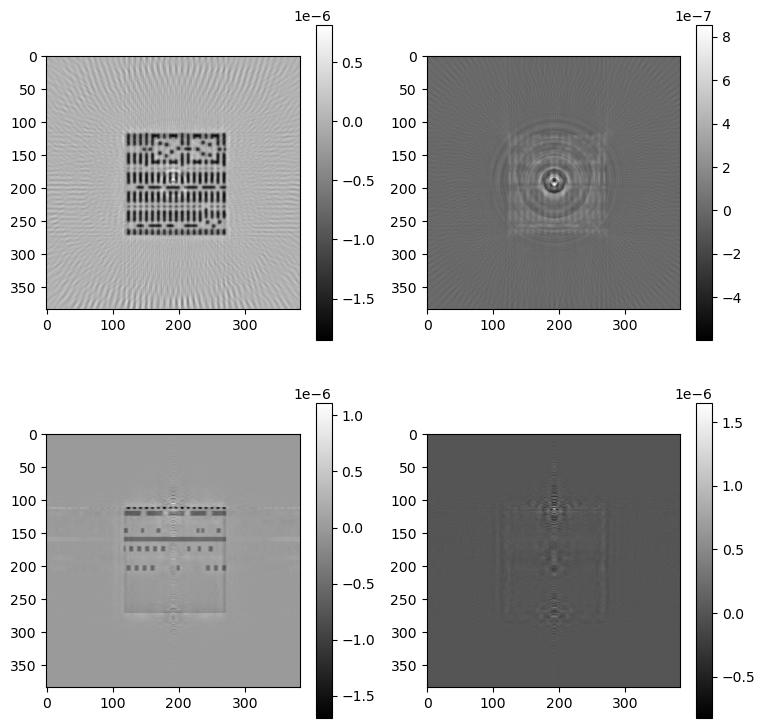

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(urec[49+nz//2-256//2].real,cmap='gray')
fig.colorbar(im)
im=axs[0,1].imshow(urec[49+nz//2-256//2].imag,cmap='gray')
fig.colorbar(im)
im=axs[1,0].imshow(urec[:,n//2].real,cmap='gray')
fig.colorbar(im)
im=axs[1,1].imshow(urec[:,n//2].imag,cmap='gray')
fig.colorbar(im)